In [2]:
import matplotlib.pyplot as plt

from prysm import mathops, conf
mathops.set_backend_to_cupy()
# conf.config.precision = 32

from prysm.mathops import (np,
                           fft,
                           interpolate,
                           ndimage)

from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.propagation import focus_fixed_sampling
from prysm.propagation import Wavefront as WF
from prysm.geometry import circle,spider
from prysm.polynomials import (
    noll_to_nm,
    zernike_nm,
    zernike_nm_seq,
    hopkins,
    sum_of_2d_modes
)


from lina.phase_retrieval import ADPhaseRetireval, ParallelADPhaseRetrieval

from scipy.optimize import minimize
from psd_utils import PSDUtils

import logging
psd_log = logging.getLogger('__psd_utils__')
psd_log.disabled = True

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Model Parameters

Text(0.5, 0, 'mm')

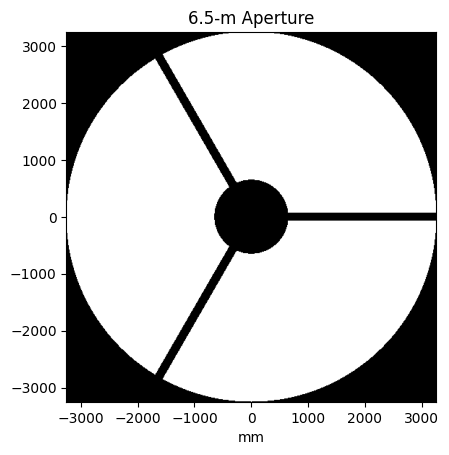

In [7]:
# parameters
D_pupil = 6500                              # mm
D_obs = 1300                                # mm
D_spider = 150                              # mm
fno = 15                                    # dimensionless
efl = fno * D_pupil                         # mm
wvls = list(np.linspace(0.575, 0.725, 25).get())  # um [0.633]
npix_pupil = 512                            # pix
dx_pupil = D_pupil / npix_pupil

defocus_values = np.asarray([0, 0.25, 0.5, 0.75, 1])

# grids
x, y = make_xy_grid(npix_pupil, diameter=D_pupil)
r, t = cart_to_polar(x, y)
extent_pupil = [-D_pupil / 2, D_pupil / 2, -D_pupil / 2, D_pupil / 2]

# image space
angular_res = (wvls[-1] + wvls[0] / 2) * 1e-6 * fno 
platescale = 3.76e-6 / angular_res
extent_image = [-platescale * 64, platescale * 64, -platescale * 64, platescale * 64]

# aperture
s1 = spider(1, D_spider, x, y, rotation=0)
s2 = spider(1, D_spider, x, y, rotation=120)
s3 = spider(1, D_spider, x, y, rotation=240)
spiders = s1 & s2 & s3
A = (circle(D_pupil / 2, r) ^ circle(D_obs / 2, r)) & spiders
# A = circle(D_pupil / 2, r)

plt.imshow(A.get(), extent=extent_pupil ,cmap='gray')
plt.title("6.5-m Aperture")
plt.xlabel("mm")

## High-Order Error

PSD now scaled to RMS.
PSD now scaled to RMS.
PSD now scaled to RMS.
PSD now scaled to RMS.


Text(0.5, 1.0, 'Optical Surface Error\nRMS: 28.1 nm')

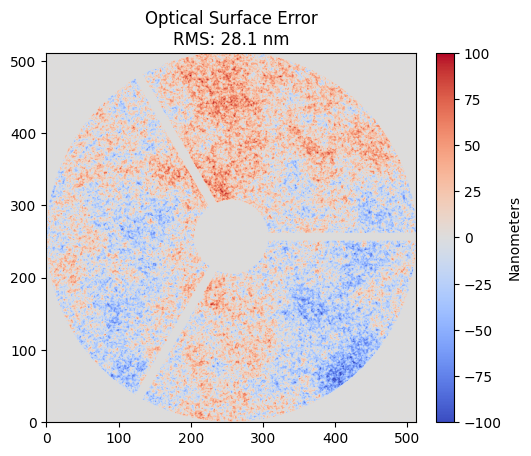

In [4]:
# surface error
coords = PSDUtils.coord_arrays(dims=(npix_pupil, npix_pupil), dx=D_pupil / 1e3 / npix_pupil)
psd = PSDUtils.abc_psd(coords=coords, a=1, b=0.1, c=2.8, rms=18.8, rms_scaling=True)
surface_error = np.asarray(PSDUtils.create_map(coords, psd, rms=18.8, seed=727).map) * A
for i in range(3):
    psd = PSDUtils.abc_psd(coords=coords, a=1, b=10, c=2.65, rms=12, rms_scaling=True)
    surface_error += np.asarray(PSDUtils.create_map(coords, psd, rms=12, seed=i + 73).map) * A

plt.imshow(surface_error.get(), vmin=-100, vmax=100, cmap='coolwarm')
plt.colorbar(fraction=0.046, pad=0.04, label='Nanometers')
plt.title("Optical Surface Error\nRMS: {:0.1f} nm".format(np.sqrt(np.mean(surface_error[surface_error != 0] ** 2))))

## Low-Order Error

/home/derbyk/src/prysm/prysm/polynomials/__init__.py:107: UserWarning: sum_of_2d_modes: modes is a list or tuple: for optimal performance, pre convert to array of shape (k, m, n)
  warnings.warn('sum_of_2d_modes: modes is a list or tuple: for optimal performance, pre convert to array of shape (k, m, n)')


Text(0.5, 0, 'mm')

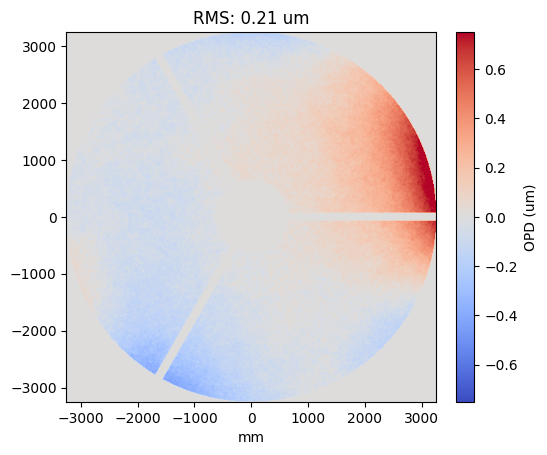

In [5]:
# zernike basis
r_norm = r / (D_pupil / 2)
nms = [noll_to_nm(i) for i in range(2, 37)]
zernikes = list(zernike_nm_seq(nms, r, t, norm=True))
zernikes = [z / np.max(np.abs(z)) for z in zernikes]

# random phase error to estimate
np.random.seed(20240820)
zernike_coeffs = np.random.random(len(nms)) * 0.2
opd = sum_of_2d_modes(zernikes, zernike_coeffs) + surface_error / 1e3

plt.imshow(opd.get() * A.get(), extent=extent_pupil, vmin=-0.75, vmax=0.75, cmap='coolwarm')
plt.colorbar(pad=0.04, fraction=0.046, label="OPD (um)")
plt.title(f"RMS: {np.sqrt(np.mean(opd[opd != 0] ** 2)):0.2f} um")
plt.xlabel("mm")

## Field-Dependent Error

/home/derbyk/src/prysm/prysm/polynomials/__init__.py:107: UserWarning: sum_of_2d_modes: modes is a list or tuple: for optimal performance, pre convert to array of shape (k, m, n)
  warnings.warn('sum_of_2d_modes: modes is a list or tuple: for optimal performance, pre convert to array of shape (k, m, n)')


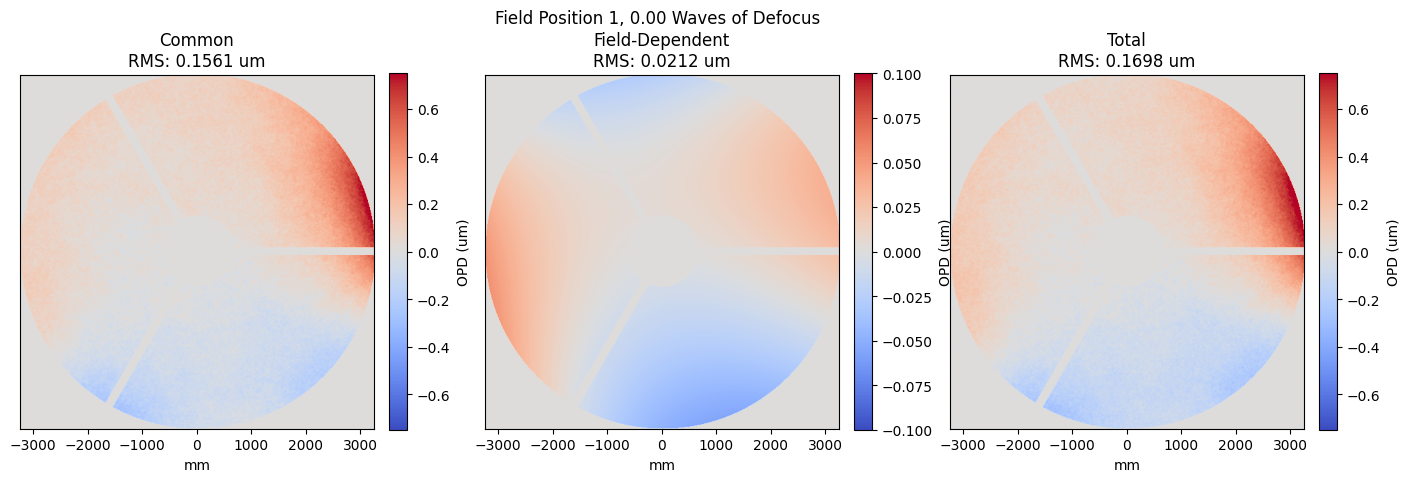

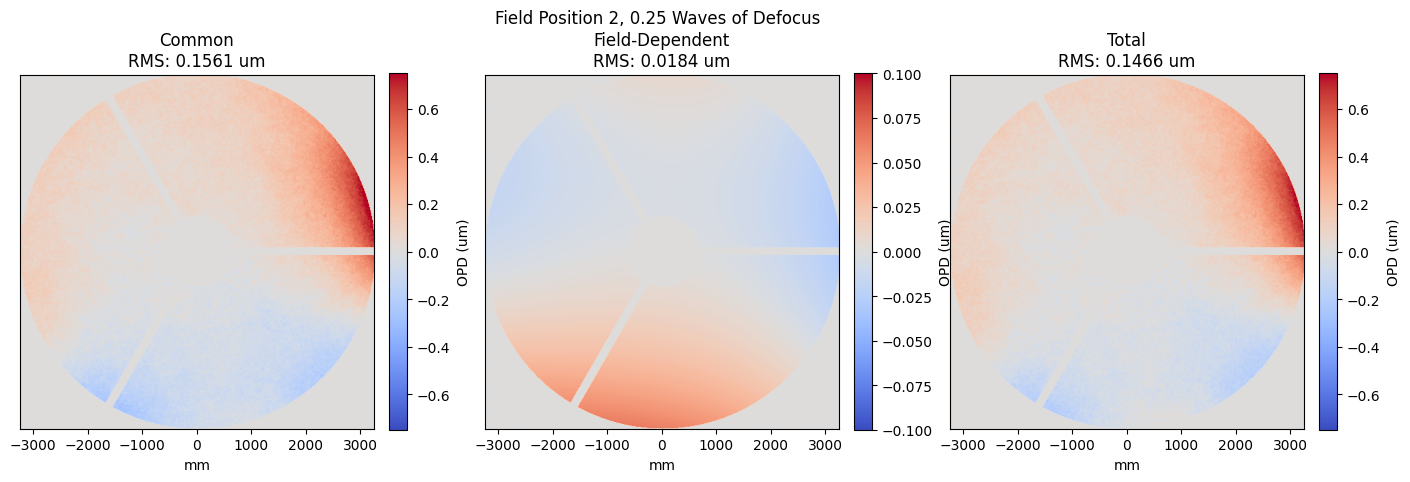

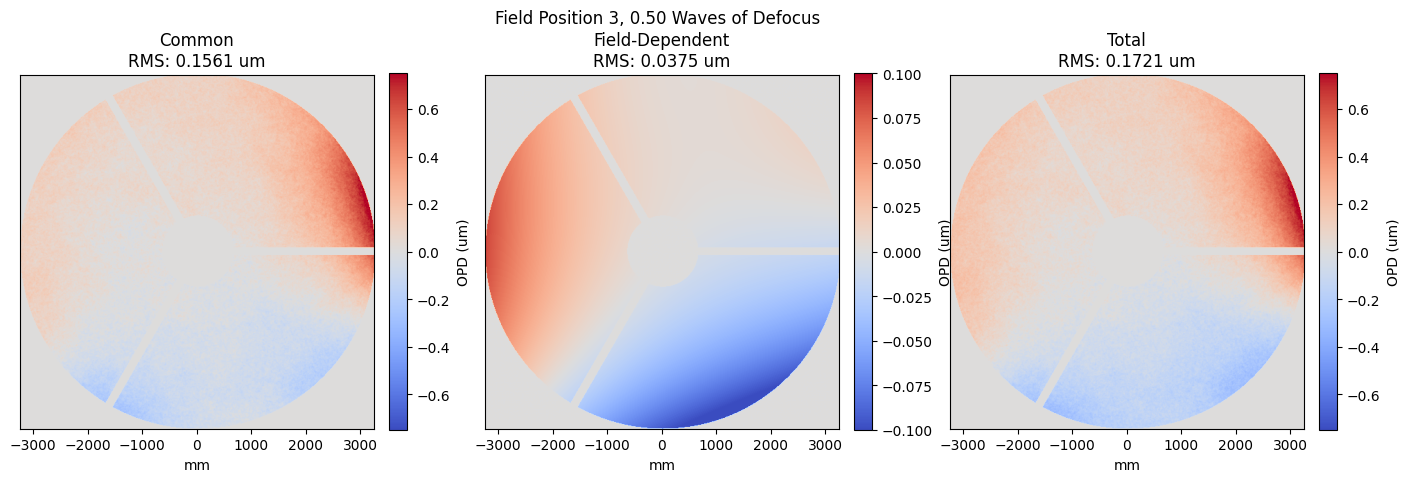

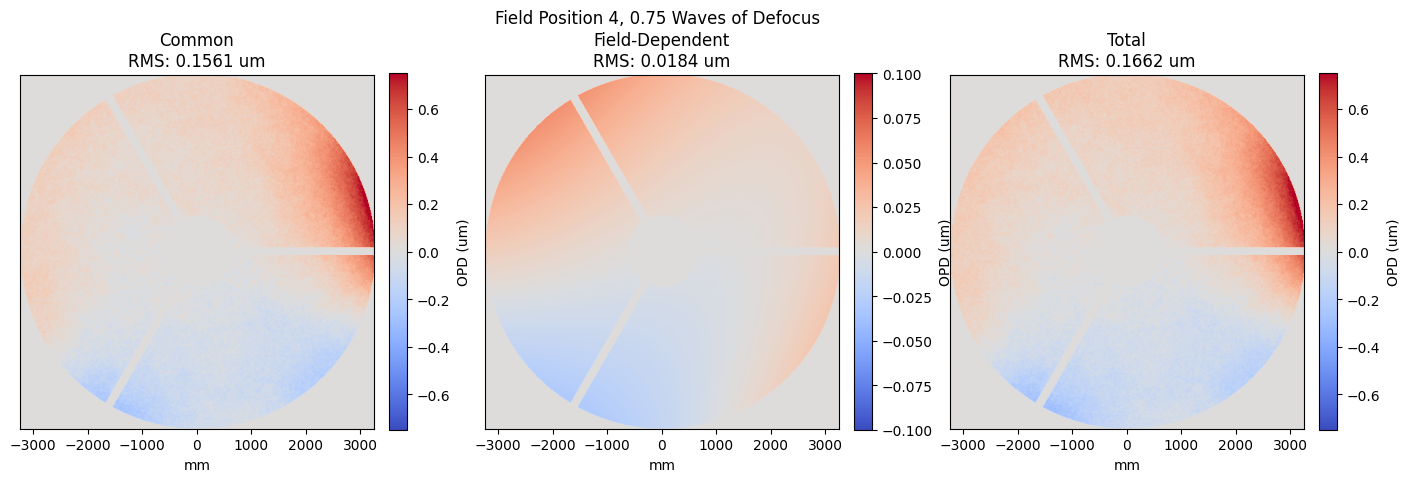

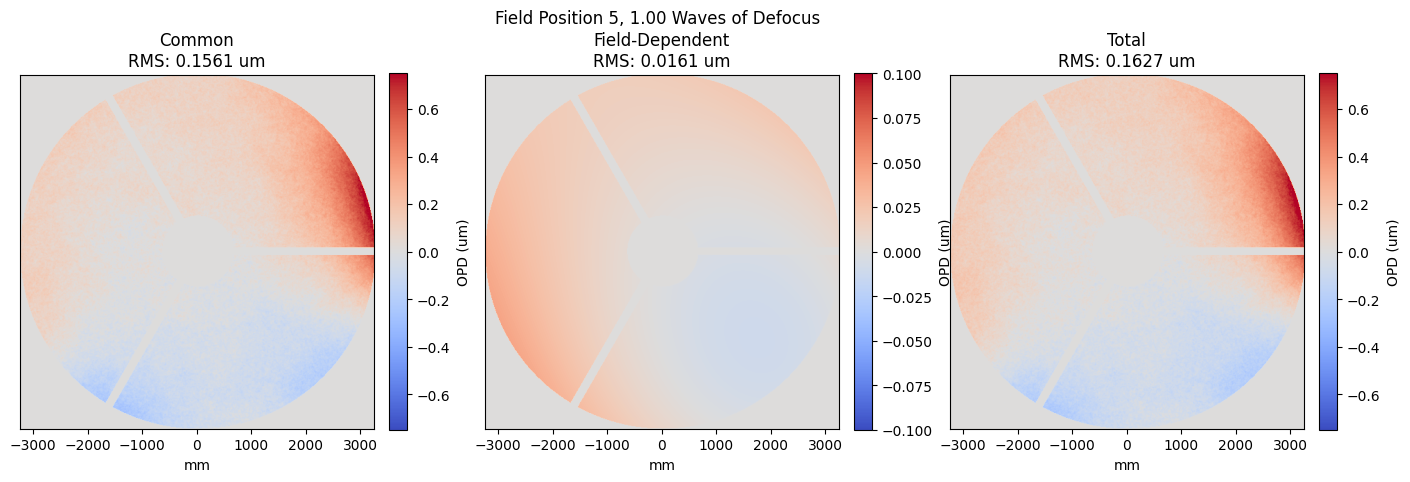

In [8]:
# all the zernikes
r_norm = r / (D_pupil / 2)
nms = [noll_to_nm(i) for i in range(2, 37)]
zernikes = list(zernike_nm_seq(nms, r, t, norm=True))
zernikes = [z / np.max(np.abs(z)) for z in zernikes]

# field dependent zernikes
nms_field = [noll_to_nm(i) for i in range(2, 9)] # tip/tilt, defocus, astig, coma
zernikes_field = list(zernike_nm_seq(nms_field, r, t, norm=True))
zernikes_field = [z / np.max(np.abs(z)) for z in zernikes_field]

# common zernikes
nms_common = [noll_to_nm(i) for i in range(9, 50)] # the rest
zernikes_common = list(zernike_nm_seq(nms_common, r, t, norm=True))
zernikes_common = [z / np.max(np.abs(z)) for z in zernikes_common]

# common phase error
np.random.seed(69)
zernike_coeffs = np.random.random(len(zernikes)) * 0.2
opd = sum_of_2d_modes(zernikes, zernike_coeffs) + surface_error / 1e3

# field dependent phase errors
opds = []
opds_field = []
np.random.seed(420)
for i in range(len(defocus_values)):
    zernike_field_coeffs = np.random.uniform(-1, 1, len(nms_field)) * 0.05
    opds_field.append(sum_of_2d_modes(zernikes_field, zernike_field_coeffs))
    opds.append(opd + opds_field[-1])

for i, (opd_field, opd_total) in enumerate(zip(opds_field, opds)):

    plt.figure(figsize=(17, 5))
    plt.subplot(131)
    plt.imshow(opd.get() * A.get(), extent=extent_pupil, vmin=-0.75, vmax=0.75, cmap='coolwarm')
    plt.colorbar(pad=0.04, fraction=0.046, label="OPD (um)")
    plt.title(f"Common\nRMS: {np.sqrt(np.mean(opd[A.astype(bool)] ** 2)):0.4f} um")
    plt.xlabel("mm"); plt.yticks([])

    plt.subplot(132)
    plt.imshow(opd_field.get() * A.get(), extent=extent_pupil, vmin=-0.1, vmax=0.1, cmap='coolwarm')
    plt.colorbar(pad=0.04, fraction=0.046, label="OPD (um)")
    plt.title(f"Field-Dependent\nRMS: {np.sqrt(np.mean(opd_field[A.astype(bool)] ** 2)):0.4f} um")
    plt.xlabel("mm"); plt.yticks([])

    plt.subplot(133)
    plt.imshow(opd_total.get() * A.get(), extent=extent_pupil, vmin=-0.75, vmax=0.75, cmap='coolwarm')
    plt.colorbar(pad=0.04, fraction=0.046, label="OPD (um)")
    plt.title(f"Total\nRMS: {np.sqrt(np.mean(opd_total[A.astype(bool)] ** 2)):0.4f} um")
    plt.xlabel("mm"); plt.yticks([])

    plt.suptitle(f"Field Position {i + 1:0.0f}, {defocus_values[i]:0.2f} Waves of Defocus")

## Forward Model

<>:38: SyntaxWarning: invalid escape sequence '\l'
<>:38: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_623897/2275957683.py:38: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f"Defocus: {defocus_values[i]:0.2f}$\lambda$")


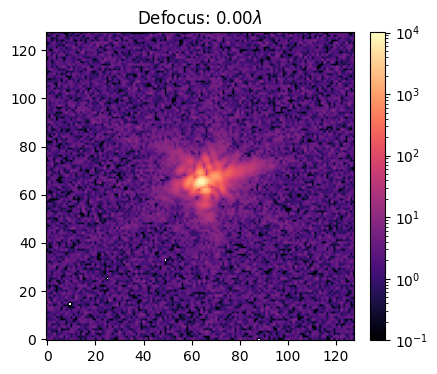

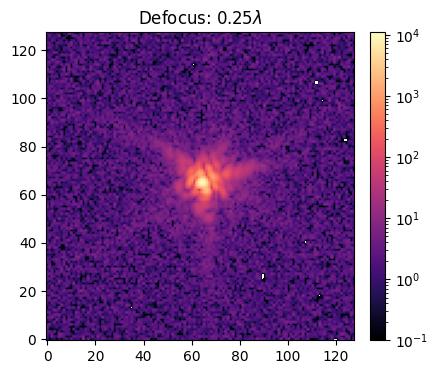

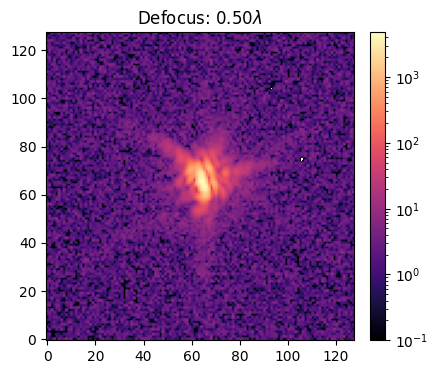

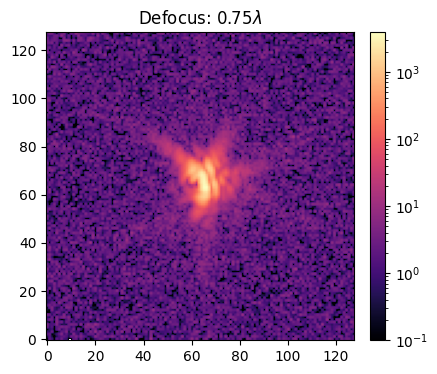

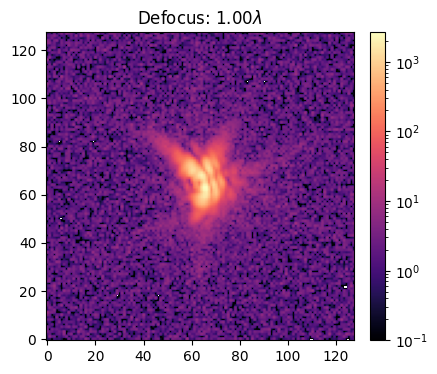

In [ ]:
def fwd(opds, defocus_values):

    # defocus OPDs
    defocus_opds = [hopkins(0, 2, 0, r_norm, t, 0) * val for val in defocus_values]

    psf_list = []

    # propagate PSFs
    for i, opd in enumerate(opds):
        psf = 0
        for wvl in wvls:
            k = 2 * np.pi / wvl
            wf = A * np.exp(1j * k * opd)
            defocus = A * np.exp(-2j * np.pi * defocus_opds[i])
            mono = focus_fixed_sampling(wavefunction=wf * defocus,
                                    input_dx=dx_pupil,
                                    prop_dist=efl,
                                    wavelength=wvl,
                                    output_dx=3.76,
                                    output_samples=128)
            psf += np.abs(mono) ** 2 / len(wvls)

            psf += np.random.normal(loc=0, scale=0.5, size=(psf.shape[0], psf.shape[1]))
            psf[psf < 0] = 0
            
        psf_list.append(psf)

    return psf_list

psfs = fwd(opds, defocus_values)

for i, psf in enumerate(psfs):
    plt.figure(figsize=(5, 4))
    plt.imshow(psf.get(), cmap='magma', norm='log', vmin=1e-1)
    plt.colorbar(pad=0.04, fraction=0.046)
    plt.title(f"Defocus: {defocus_values[i]:0.2f}$\lambda$")

## BING BONG

In [10]:
def bing_bong(psfs, parameters, disp=True):

    results = []

    for i, parameter in enumerate(parameters):
        if parameter['type'] == 'joint':
            
            # get relevant info from parameters
            ind_modes = parameter['independent_modes']
            common_modes = parameter['common_modes']
            ind_gain = parameter['independent_gain']
            common_gain = parameter['common_gain']
            options = parameter['options']
            error_fx = parameter['error_fx']

            # construct modes and gains for joint FDPR
            modes = np.asarray(ind_modes + common_modes)
            gains = np.concatenate((np.ones((len(ind_modes),)) * ind_gain, np.ones((len(common_modes),)) * common_gain))

            # get initial phase estimates for joint FDPR
            if i == 0:
                initial_phases = []
                for j in range(len(psfs)):
                    initial_phases.append(None)
            else:
                initial_phases = results[-1]['opd_estimates']

            # make list of ADPR classes 
            adpr_list = []
            for j in range(len(psfs)):
                adpr_list.append(ADPhaseRetireval(amp=A,
                                                  amp_dx=dx_pupil,
                                                  efl=efl,
                                                  wvls=wvls,
                                                  basis=modes * gains[:, None, None],
                                                  target=psfs[j],
                                                  img_dx=3.76,
                                                  defocus_waves=defocus_values[j],
                                                  initial_phase=initial_phases[j],
                                                  error_function=error_fx))

            # shove em into FDPR and optimize
            fdpr = ParallelADPhaseRetrieval(optlist=adpr_list)
            result = minimize(fdpr.fg, x0=np.zeros(len(modes)).get(), jac=True, method='L-BFGS-B', options=options).x

            # get the optimized modal coefficients
            coeffs = []
            if i == 0:
                for j in range(len(psfs)):
                    coeffs.append(result * gains.get())
            else:
                for j in range(len(psfs)):
                    coeffs.append(results[-1]['coefficients'][j] + result * gains.get())

            # turn those coefficients into some OPD maps
            opd_estimates = []
            for j in range(len(psfs)):
                opd_estimates.append(sum_of_2d_modes(modes, np.asarray(coeffs[j])))

            # grab the PSF estimates and error function costs as well
            psf_estimates = []
            costs = []
            for opt in fdpr.optlist:
                psf_estimates.append(opt.I.get())
                costs.append(np.asarray(opt.cost).get())

            # throw in results
            results.append({'coefficients'  : coeffs,
                            'opd_estimates' : opd_estimates,
                            'psf_estimates' : psf_estimates,
                            'costs'         : costs})

            # if desired, display costs
            if disp:
                for j, opt in enumerate(fdpr.optlist):
                    plt.plot(np.asarray(opt.cost).get(), label=f'Defocus : {defocus_values[j]:0.2f}$\lambda$', alpha=0.4)
                plt.title('BING')
                plt.ylabel('Error Function')
                plt.xlabel('Iterations')
                plt.legend(loc='upper right')
                plt.yscale('log')
                plt.show()

        elif parameter['type'] == 'individual':
            
            # get relevant info from parameters
            ind_modes = parameter['independent_modes']
            common_modes = parameter['common_modes']
            ind_gain = parameter['independent_gain']
            common_gain = parameter['common_gain']
            options = parameter['options']
            error_fx = parameter['error_fx']

            # construct modes and gains for individual ADPR routines
            modes = np.asarray(ind_modes + common_modes)
            gains = np.concatenate((np.ones((len(ind_modes),)) * ind_gain, np.ones((len(common_modes),)) * common_gain))

            # get initial phase estimates for individual ADPR routines
            if i == 0:
                initial_phases = []
                for j in range(len(psfs)):
                    initial_phases.append(None)
            else:
                initial_phases = results[-1]['opd_estimates']

            # make list of ADPR classes 
            adpr_list = []
            for j in range(len(psfs)):
                adpr_list.append(ADPhaseRetireval(amp=A,
                                                  amp_dx=dx_pupil,
                                                  efl=efl,
                                                  wvls=wvls,
                                                  basis=modes * gains[:, None, None],
                                                  target=psfs[j],
                                                  img_dx=3.76,
                                                  defocus_waves=defocus_values[j],
                                                  initial_phase=initial_phases[j],
                                                  error_function=error_fx))

            # optimize individual ADPR routines and get the estimated coefficients
            coeffs = []
            for j in range(len(adpr_list)):
                result = minimize(adpr_list[j].fg, x0=np.zeros(len(modes)).get(), method='L-BFGS-B', jac=True, options=options).x
                if i == 0:
                    coeffs.append(result * gains.get())
                else:
                    coeffs.append(results[-1]['coefficients'][j] + result * gains.get())

            # turn those coefficients into some OPD maps
            opd_estimates = []
            for j in range(len(psfs)):
                opd_estimates.append(sum_of_2d_modes(modes, np.asarray(coeffs[j])))

            # grab the PSF estimates and error function costs as well
            psf_estimates = []
            costs = []
            for opt in fdpr.optlist:
                psf_estimates.append(opt.I.get())
                costs.append(np.asarray(opt.cost).get())

            # throw in results
            results.append({'coefficients'  : coeffs,
                            'opd_estimates' : opd_estimates,
                            'psf_estimates' : psf_estimates,
                            'costs'         : costs})

            # if desired, display costs
            if disp:
                for j, opt in enumerate(adpr_list):
                    plt.plot(np.asarray(opt.cost).get(), label=f'Defocus : {defocus_values[j]:0.2f}$\lambda$', alpha=0.4)
                plt.title('BONG')
                plt.ylabel('Error Function')
                plt.xlabel('Iterations')
                plt.legend(loc='upper right')
                plt.yscale('log')
                plt.show()

    return results

<>:76: SyntaxWarning: invalid escape sequence '\l'
<>:150: SyntaxWarning: invalid escape sequence '\l'
<>:76: SyntaxWarning: invalid escape sequence '\l'
<>:150: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_623897/3214690026.py:76: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(np.asarray(opt.cost).get(), label=f'Defocus : {defocus_values[j]:0.2f}$\lambda$', alpha=0.4)
/tmp/ipykernel_623897/3214690026.py:150: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(np.asarray(opt.cost).get(), label=f'Defocus : {defocus_values[j]:0.2f}$\lambda$', alpha=0.4)


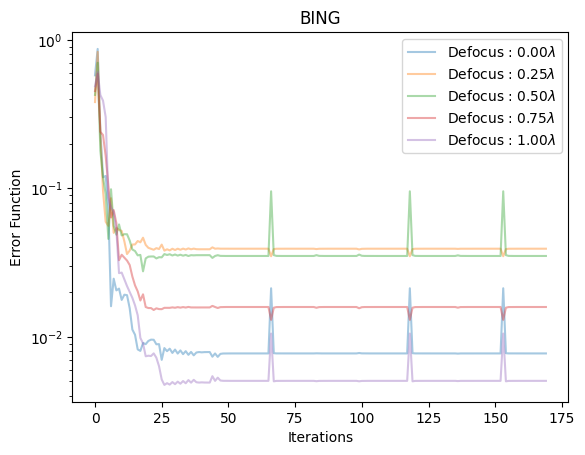

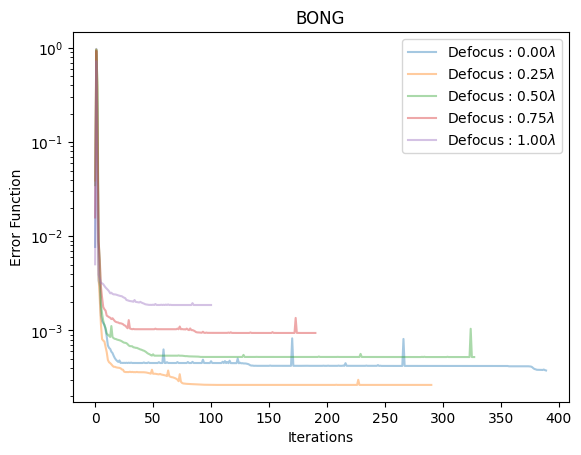

In [12]:
bing_bong_parameters = [{'type'              : 'joint',
                         'independent_modes' : zernikes_field,
                         'common_modes'      : zernikes_common,
                         'independent_gain'  : 0.75,
                         'common_gain'       : 1,
                         'error_fx'          : 'GIE',
                         'options'           : {'maxls' : 20, 'ftol' : 1e-20, 'gtol' : 1e-8, 'disp' : 0, 'maxiter' : 50}},
                        {'type'              : 'individual',
                         'independent_modes' : zernikes_field,
                         'common_modes'      : zernikes_common,
                         'independent_gain'  : 1,
                         'common_gain'       : 0.75,
                         'error_fx'          : 'GIE',
                         'options'           : {'maxls' : 20, 'ftol' : 1e-20, 'gtol' : 1e-8, 'disp' : 0, 'maxiter' : 100}},]

results = bing_bong(psfs, bing_bong_parameters, disp=True)

## Visualize Results

<>:36: SyntaxWarning: invalid escape sequence '\l'
<>:42: SyntaxWarning: invalid escape sequence '\l'
<>:36: SyntaxWarning: invalid escape sequence '\l'
<>:42: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_623897/1475622447.py:36: SyntaxWarning: invalid escape sequence '\l'
  ax4.set_xlabel('$\lambda$/D'); ax4.set_yticks([])
/tmp/ipykernel_623897/1475622447.py:42: SyntaxWarning: invalid escape sequence '\l'
  ax5.set_xlabel('$\lambda$/D'); ax5.set_yticks([])


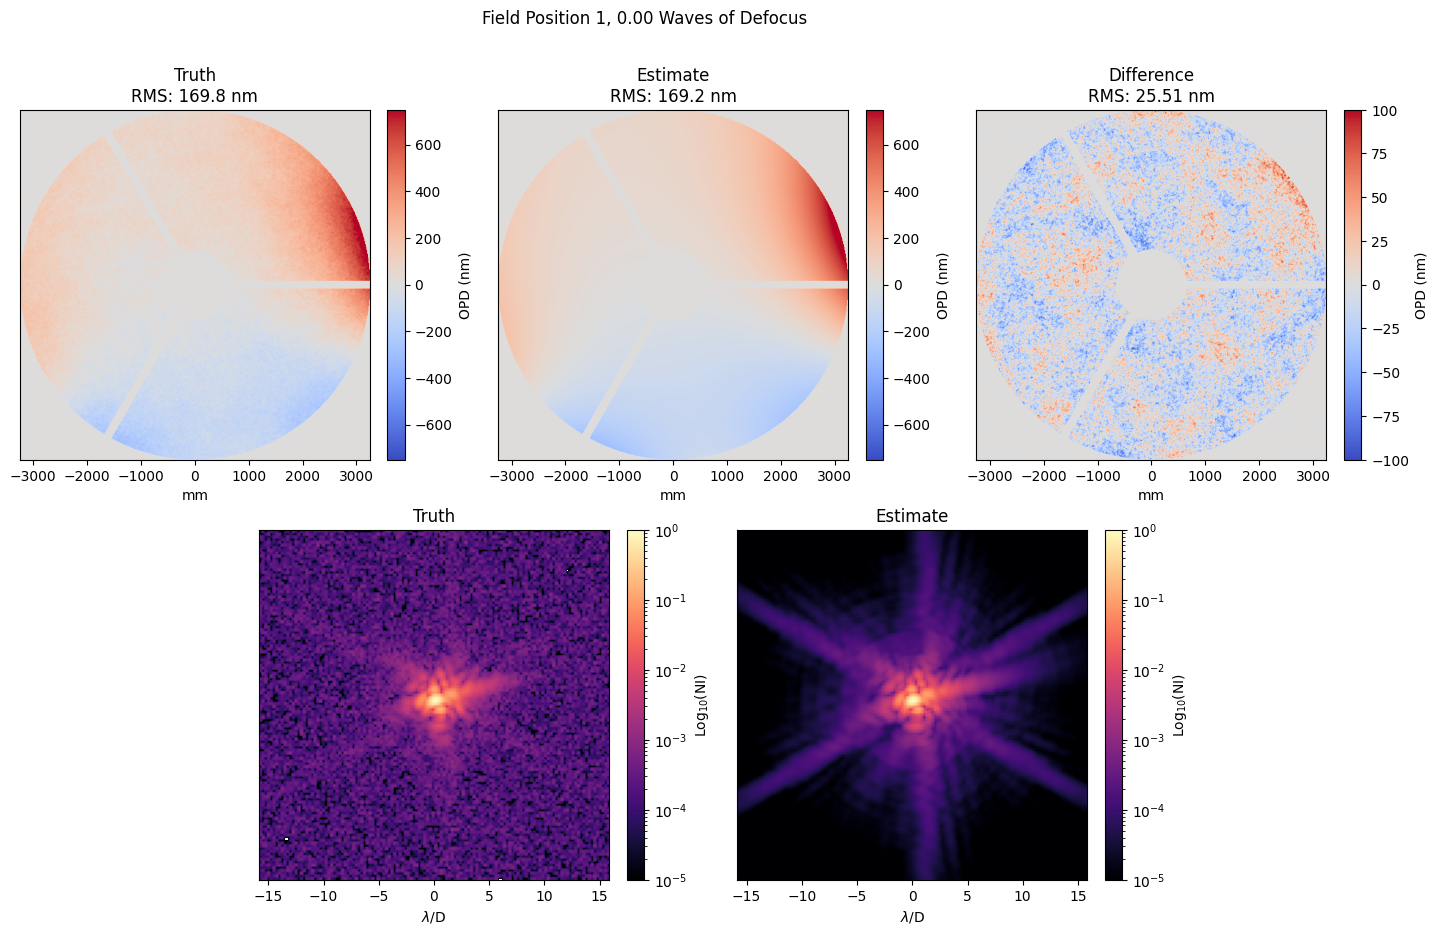

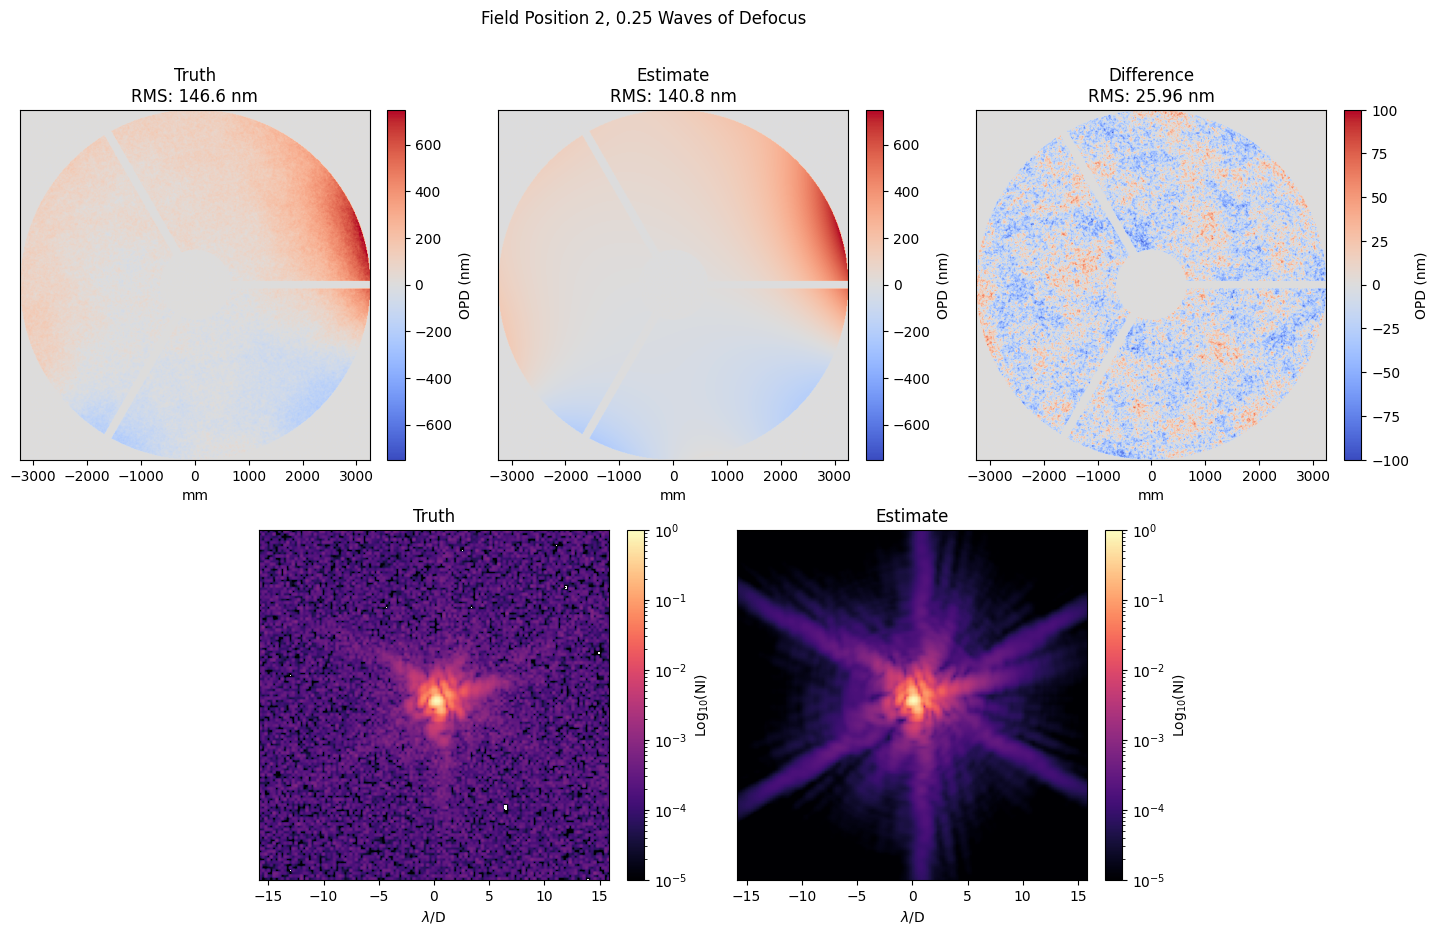

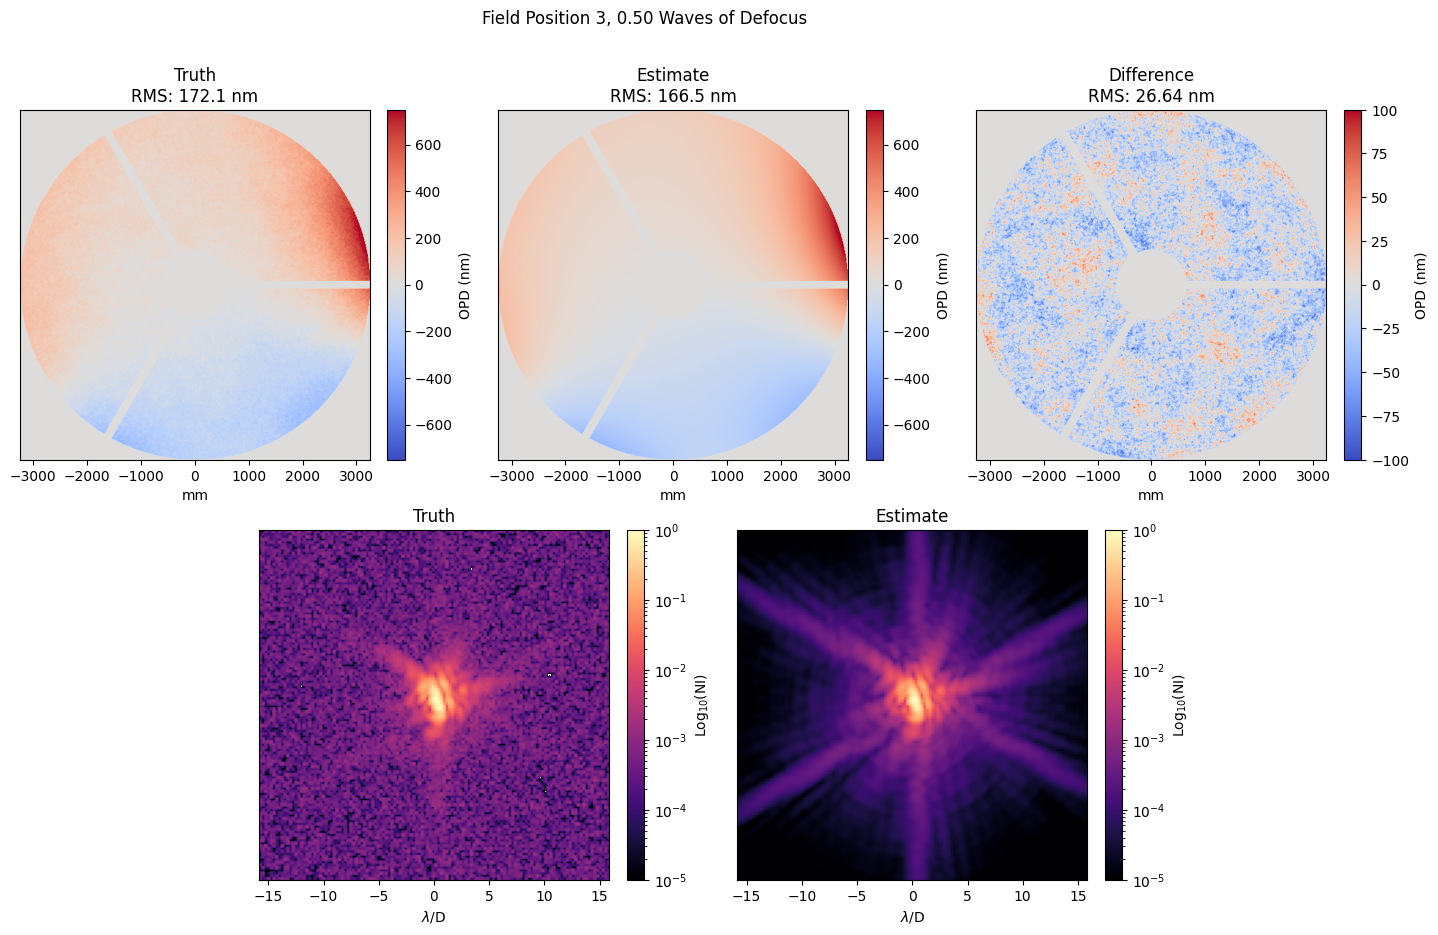

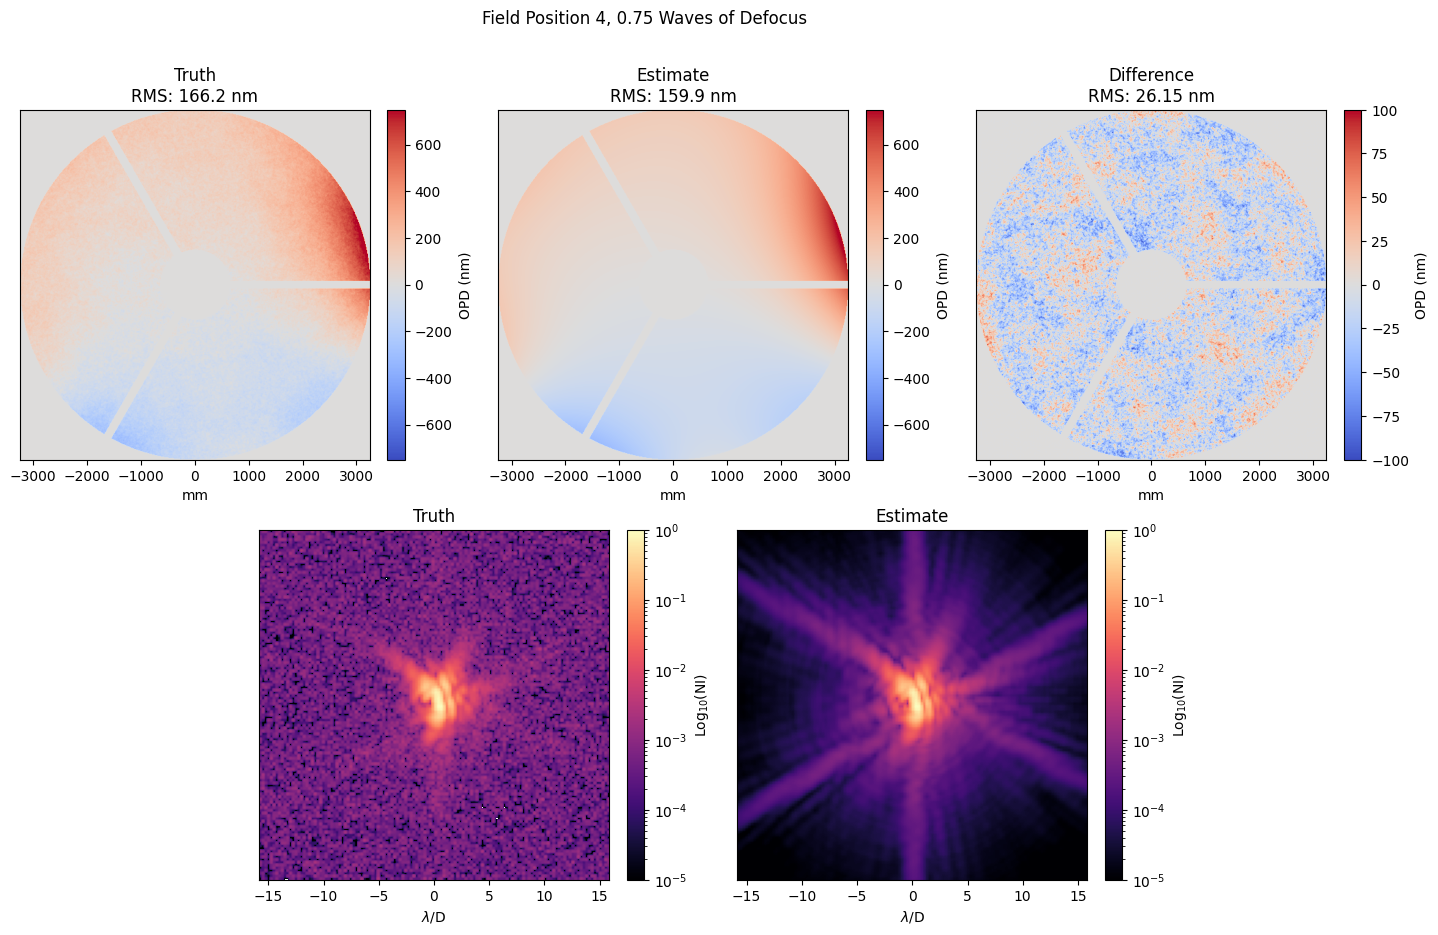

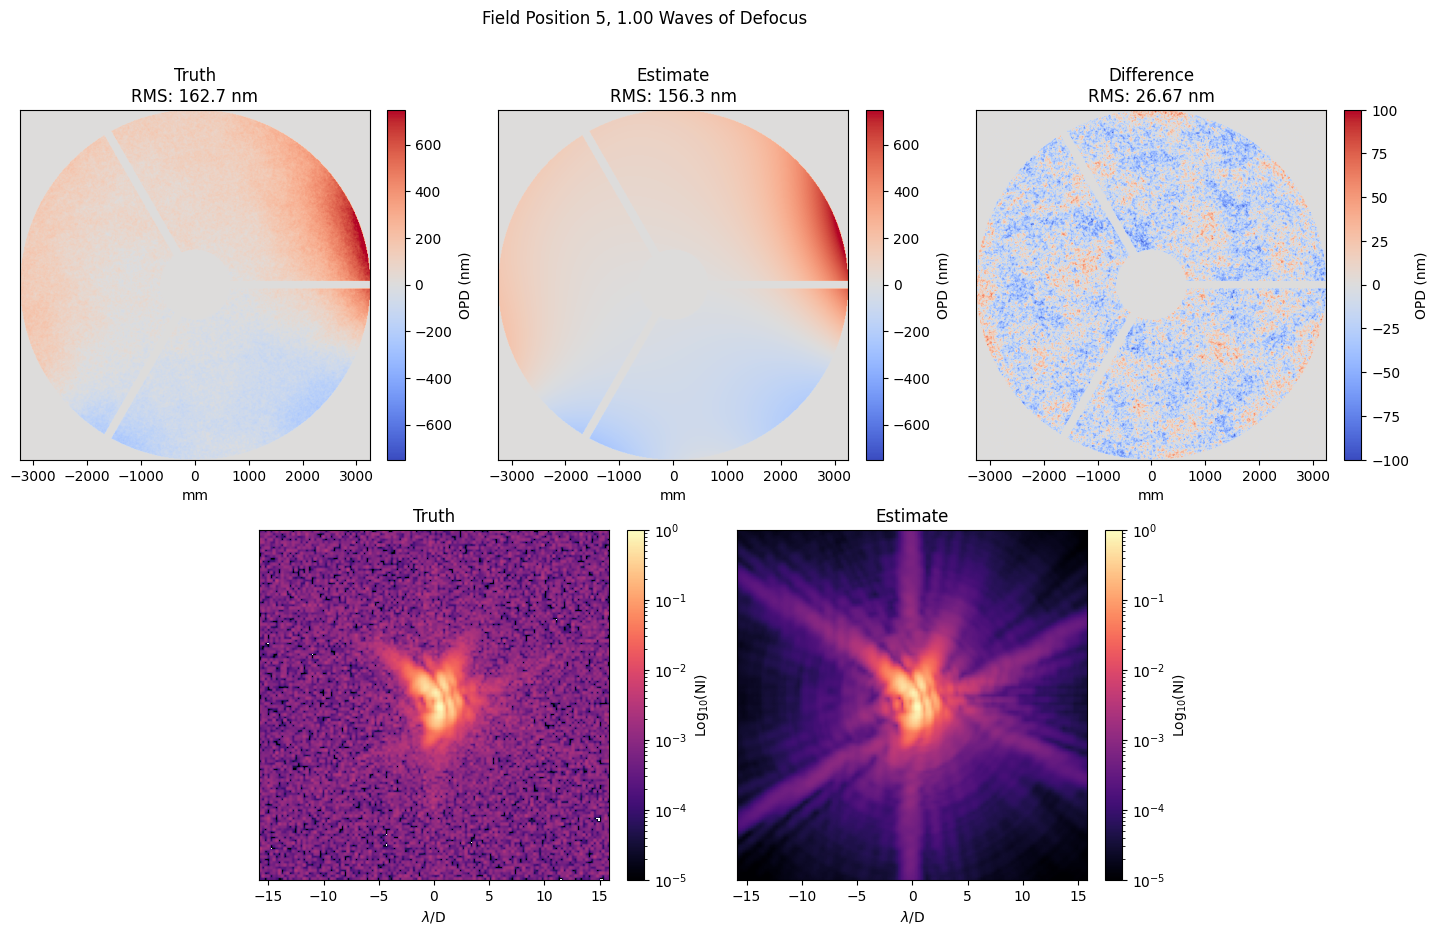

In [13]:
ind = -1

for i in range(len(psfs)):
    fig = plt.figure(figsize=(18, 10))
    spec = plt.GridSpec(ncols=6, nrows=2)

    opd_estimate = results[ind]['opd_estimates'][i] * 1e3
    opd_truth = opds[i] * 1e3
    opd_diff = opd_estimate - opd_truth

    ax1 = fig.add_subplot(spec[0, 0:2])
    map = ax1.imshow(opd_truth.get() * A.get(), extent=extent_pupil, vmin=-750, vmax=750, cmap='coolwarm')
    plt.colorbar(mappable=map, pad=0.04, fraction=0.046, label="OPD (nm)")
    ax1.set_title(f"Truth\nRMS: {np.sqrt(np.mean(opd_truth[A.astype(bool)] ** 2)):0.1f} nm")
    ax1.set_xlabel("mm"); ax1.set_yticks([])

    ax2 = fig.add_subplot(spec[0, 2:4])
    map = ax2.imshow(opd_estimate.get() * A.get(), extent=extent_pupil, vmin=-750, vmax=750, cmap='coolwarm')
    plt.colorbar(mappable=map, pad=0.04, fraction=0.046, label="OPD (nm)")
    ax2.set_title(f"Estimate\nRMS: {np.sqrt(np.mean(opd_estimate[A.astype(bool)] ** 2)):0.1f} nm")
    ax2.set_xlabel("mm"); ax2.set_yticks([])

    ax3 = fig.add_subplot(spec[0, 4:])
    map = ax3.imshow(opd_diff.get() * A.get(), extent=extent_pupil, vmin=-100, vmax=100, cmap='coolwarm')
    plt.colorbar(mappable=map, pad=0.04, fraction=0.046, label="OPD (nm)")
    ax3.set_title(f"Difference\nRMS: {np.sqrt(np.mean(opd_diff[A.astype(bool)] ** 2)):0.2f} nm")
    ax3.set_xlabel("mm"); ax3.set_yticks([])

    psf_estimate = results[ind]['psf_estimates'][i]
    psf_truth = psfs[i].get()

    ax4 = fig.add_subplot(spec[1, 1:3])
    map = ax4.imshow(psf_truth / psf_truth.max(), extent=extent_image, norm='log', vmin=1e-5, cmap='magma')
    plt.colorbar(mappable=map, pad=0.04, fraction=0.046, label='Log$_{10}$(NI)')
    ax4.set_title('Truth')
    ax4.set_xlabel('$\lambda$/D'); ax4.set_yticks([])

    ax5 = fig.add_subplot(spec[1, 3:5])
    map = ax5.imshow(psf_estimate / psf_estimate.max(), extent=extent_image, norm='log', vmin=1e-5, cmap='magma')
    plt.colorbar(mappable=map, pad=0.04, fraction=0.046, label='Log$_{10}$(NI)')
    ax5.set_title('Estimate')
    ax5.set_xlabel('$\lambda$/D'); ax5.set_yticks([])

    fig.suptitle(f"Field Position {i + 1:0.0f}, {defocus_values[i]:0.2f} Waves of Defocus")